# TensorFlow Keras API
## 手動でカスタム関数を実装する
線形回帰モデルを Keras API で実装する

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

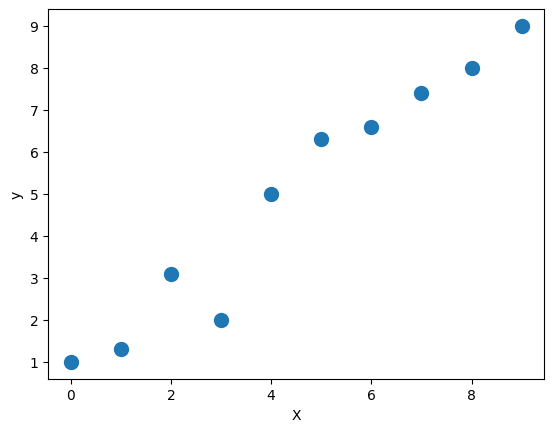

In [2]:
# データセットの作成
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])
plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [3]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
ds_train_org = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32), tf.cast(y_train, tf.float32))
)

I0000 00:00:1729118928.075881   43490 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 07:48:48.107344: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


線形回帰のモデルは $z = wx + b$ として定義される。これを Keras を使って1からモデルを定義する。
- `tf.keras.Model` をサブクラス化する.
- インスタンス変数にモデルパラメータとして $w$ と $b$ を定義する.
- `call` メソッドを定義する.このメソッドはこのモデルが入力データをどのように使って出力を生成するのかを決める.

In [9]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w * x + self.b

モデルをインスタンス化する。モデルの `summary` メソッドを使用するために `build` を呼び出し、このモデルに期待される入力データの形状を指定する。このことを遅延変数作成と呼ぶ。

In [12]:
model = MyModel()
model.build(input_shape=(None, 1)) # None=minibatch size, 1 is x_dim
model.summary()

Model: "my_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

コスト関数を定義する。今回は平均二乗誤差を選択する。またモデルの重みパラメータの学習には確率的勾配降下法を使う。勾配を計算するために `tf.GradientTape` を使う。

In [6]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred)) # tf で作っておけばバッチが来てもおっけー

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

- ハイパーパラメータや訓練epoch数を指定する
- データをバッチにする

In [9]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_org.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []


- バッチごとに学習をさせてすべてのデータを使い、これをエポック数回分繰り返す

In [17]:
for i, batch in enumerate(ds_train): # batch と言ってるが minibatch のことだし、今回は1つのデータ（確率的勾配降下法）
    if i >= steps_per_epoch * num_epochs:
        break # 無限ループをぬける
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by) # cost 関数の評価

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print(f"Epoch {int(i/steps_per_epoch)} Step {i} Loss {loss_val}")

Epoch 0 Step 0 Loss 43.55999755859375
Epoch 10 Step 100 Loss 0.7530134320259094
Epoch 20 Step 200 Loss 20.175859451293945
Epoch 30 Step 300 Loss 23.397605895996094
Epoch 40 Step 400 Loss 6.348119258880615
Epoch 50 Step 500 Loss 4.635603427886963
Epoch 60 Step 600 Loss 0.24105073511600494
Epoch 70 Step 700 Loss 0.20362770557403564
Epoch 80 Step 800 Loss 3.8176910877227783
Epoch 90 Step 900 Loss 0.9416388869285583
Epoch 100 Step 1000 Loss 0.7034985423088074
Epoch 110 Step 1100 Loss 0.034772761166095734
Epoch 120 Step 1200 Loss 0.5403661131858826
Epoch 130 Step 1300 Loss 0.11702598631381989
Epoch 140 Step 1400 Loss 0.11948295682668686
Epoch 150 Step 1500 Loss 0.09437620639801025
Epoch 160 Step 1600 Loss 0.4670370817184448
Epoch 170 Step 1700 Loss 2.0694775581359863
Epoch 180 Step 1800 Loss 0.001972649712115526
Epoch 190 Step 1900 Loss 0.3612426519393921


Final Parameters: 2.6576622 4.8798566


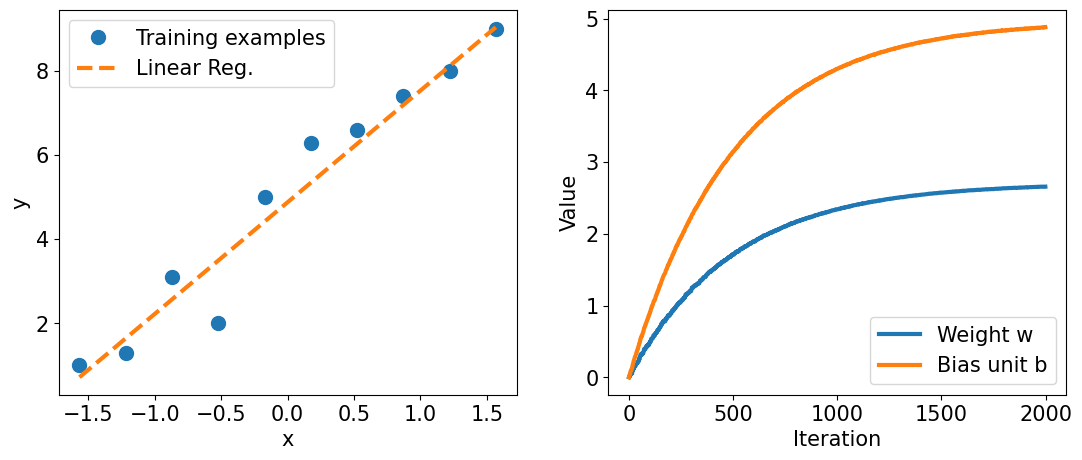

In [18]:
# 可視化
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('ch13-linreg-1.pdf')

plt.show()

## compile と fit をつかう

インスタンス化したモデルから呼び出せる `fit` メソッドを使うとカスタム関数 `train` をわざわざ実装しなくても済む。学習時には最適化のアルゴリズムとコスト関数が必要となるので、モデルをコンパイルするときにそれら（と評価指標）を指定する。

In [22]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b
    
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [23]:
tf.random.set_seed(1)
model = MyModel()
model.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['mae', 'mse'])

In [28]:
tf.random.set_seed(1)
model = MyModel()
# model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

`fit` メソッドにはバッチ化したデータセットを渡すこともできるが、 Numpy配列を直接渡すこともできる。この場合はわざわざデータセットを作成する必要はない。

In [25]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.3556 - mae: 4.4306 - mse: 26.3556  
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.3556 - mae: 4.4306 - mse: 26.3556  
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.2937 - mae: 4.5068 - mse: 27.2937  
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.1581 - mae: 4.4980 - mse: 27.1581 
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.1581 - mae: 4.4980 - mse: 27.1581  
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.3556 - mae: 4.4306 - mse: 26.3556  
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.6202 - mae: 4.5270 - mse: 27.6202  
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.0775 - mae: 4.4706 - mse: 27.0775  
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.0994 - mae: 4.4928 - mse: 27.0994  
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.2937 - mae: 4.5068 - mse: 27.2937  
Epoch 11/200
10/10 ━

0.0 0.0


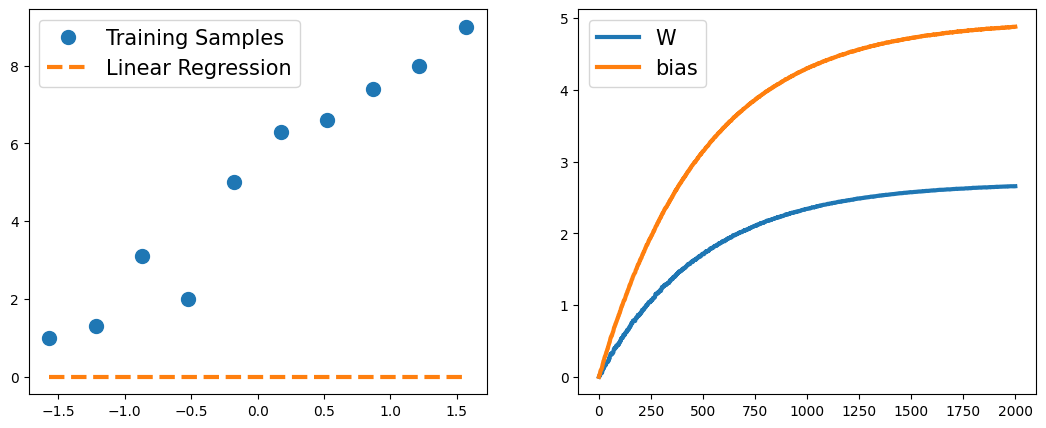

In [29]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

`fit` で学習できてないし、可視化の W と bias は前のほうの実装の結果を可視化しているだけだし、なんか記載のコードがぜんぜん違っている気がするのと、`summary` をみたときにモデルパラメータが0個になるのも気になる。

# 多層パーセプトロンの構築
- `tf.keras.layers` を使う

In [3]:
# data load
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info)

2024-10-17 20:39:10.351834: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/home/hoyo/work/training/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:03<00:00,  3.62s/ url]

Extraction completed...: 100%|██████████| 4/4 [00:03<00:00,  1.10 file/s]
Dl Size...: 0 MiB [00:03, ? MiB/s]
Dl Completed...: 100%|██████████| 1/1 [00:03<00:00,  3.65s/ url]
I0000 00:00:1729165156.166113    1063 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Dataset iris downloaded and prepared to /home/hoyo/tensorflow_datasets/iris/2.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.1.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_dir=PosixGPath('/tmp/tmp7pwf5otptfds'),
    file_format=tfrecord,
    download_size=3.65 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
  

2024-10-17 20:39:16.371890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# take と skip でデータを分割する
tf.random.set_seed(1)
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False) # train と test が混ざらないように指定
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

In [ ]:
# dictionary to tuple
ds_train_orig = ds_train_orig.map(lambda x: (x['features'], x['label']))
ds_test = ds_test.map(lambda x: (x['features'], x['label']))

今回は `Dense`層を使う。これは全結合層とか線形層とも呼ばれ、$f(w \times x + b$ によって表現される。

ここでは2つの隠れ層で構成されたモデルを定義する。
- 1つ目は4つの特徴量からなる入力を受け取り、16個のニューロンに射影する
- 2つ目は前の層の出力（サイズは16）を受け取り、3つの出力ニューロンに射影する（クラスラベルが3つ）

In [7]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, activation='softmax', name='fc2')
])
iris_model.summary()

/home/hoyo/work/training/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

parameter の数は、(4+1)*16=80、(16+1)*3 = 51 (bias 分が1足されている)。最後の層で activation に softmax を用いているのは、これが多クラス分類をサポートしているからである。

つぎに、コンパイルを行う。コンパイルのときに、損失関数（Loss）、最適化アルゴリズム（オプティマイザ）、評価指標を指定する

In [13]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [19]:
# 学習のパラメータを決める
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size).astype(np.int32)
ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)
history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, verbose=0)

prefetch メソッドは、次の要素を事前に読み込んで、内部バッファに格納します。これにより、モデルが次のバッチを要求したときに、データがすぐに利用できるようになり、GPUやTPUなどのアクセラレータがアイドル状態になる時間を減らすことができます

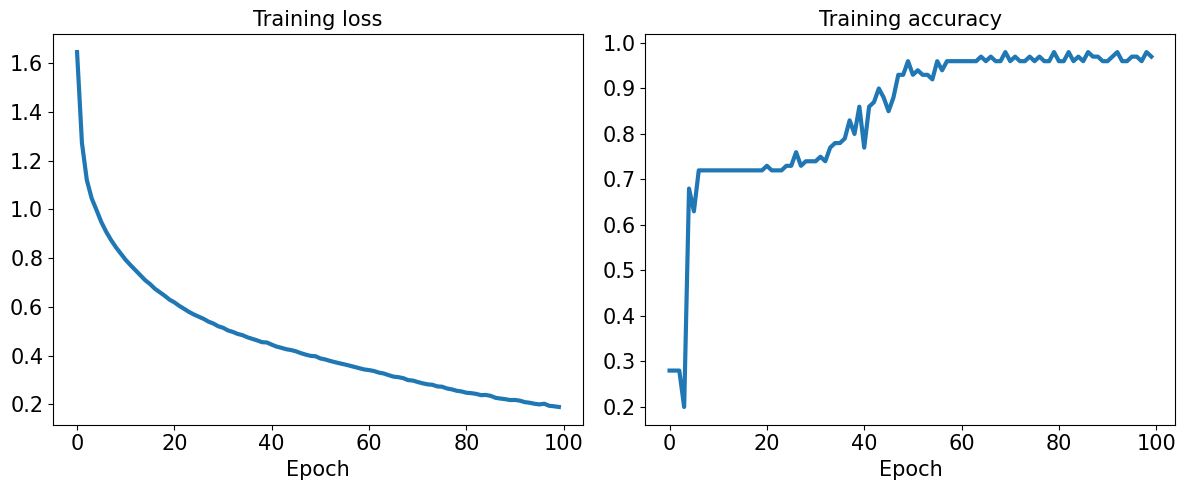

In [20]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

モデルに正しい次元（階数）の入力が渡されるよう、テストデータもバッチ化してそのデータの階数をそろえなければならない。階数さえそろっていれば、バッチのサイズ自体は重要ではない。

In [27]:
results = iris_model.evaluate(ds_test.batch(50), verbose=1)
print(f'Test loss: {results[0]:.4f} Test Acc.: {results[1]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9800 - loss: 0.1979


Test loss: 0.1979 Test Acc.: 0.9800
